# Implementing Compositional General Value Functions using TD(0) in Cycle World and Gridworld

In [125]:
import sys
!{sys.executable} -m pip install pygame
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install latex
!{sys.executable} -m pip install Ghostscript > 9.0

In [38]:
import gym
import pygame
import gym_examples
env = gym.make('gym_examples/GridWorld-v0')

In [39]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]


## Cycle World 

In [44]:
#Building the Environment
reward = 0
g = 0.9
observation = 0
#number of compositions, max: 9
n = 5
#Tabular Value Function
v = []

for k in range(n):
    v.append([])
    for i in range(10):
            v[k].append(0)
            
#Learning GVFs
for i in range(1,100000):    
    #For the first GVP, we use Reward as the cumulant
    observation_next = i%10
    if i%10 == 0:
        reward = 1
    else: 
        reward = 0
    v[0][observation] = v[0][observation] + 0.01*(reward + g*v[0][observation_next] - v[0][observation])
    for k in range(1,n):
        v[k][observation] = v[k][observation] + 0.01*(v[k-1][observation] + g*v[k][observation_next] - v[k][observation])
    observation = observation_next

    

In [45]:
#Environment
reward = 0
obs = 0

#Storing Compositions
time_step = []
cumulant = []
comp = []
state_value = []

for k in range(n):
    state_value.append(0)

for i in range(100000):
    time_step.append(i)
    obs = i%10
    if i%10 == 0:
        reward = 1
    else: 
        reward = 0
    state_value[0] = v[0][obs]
    for k in range(1,n):
        state_value[k] = v[k][obs]

    cumulant.append(reward)
    for k in range(n):
        comp.append([])
        comp[k].append(state_value[k])
        



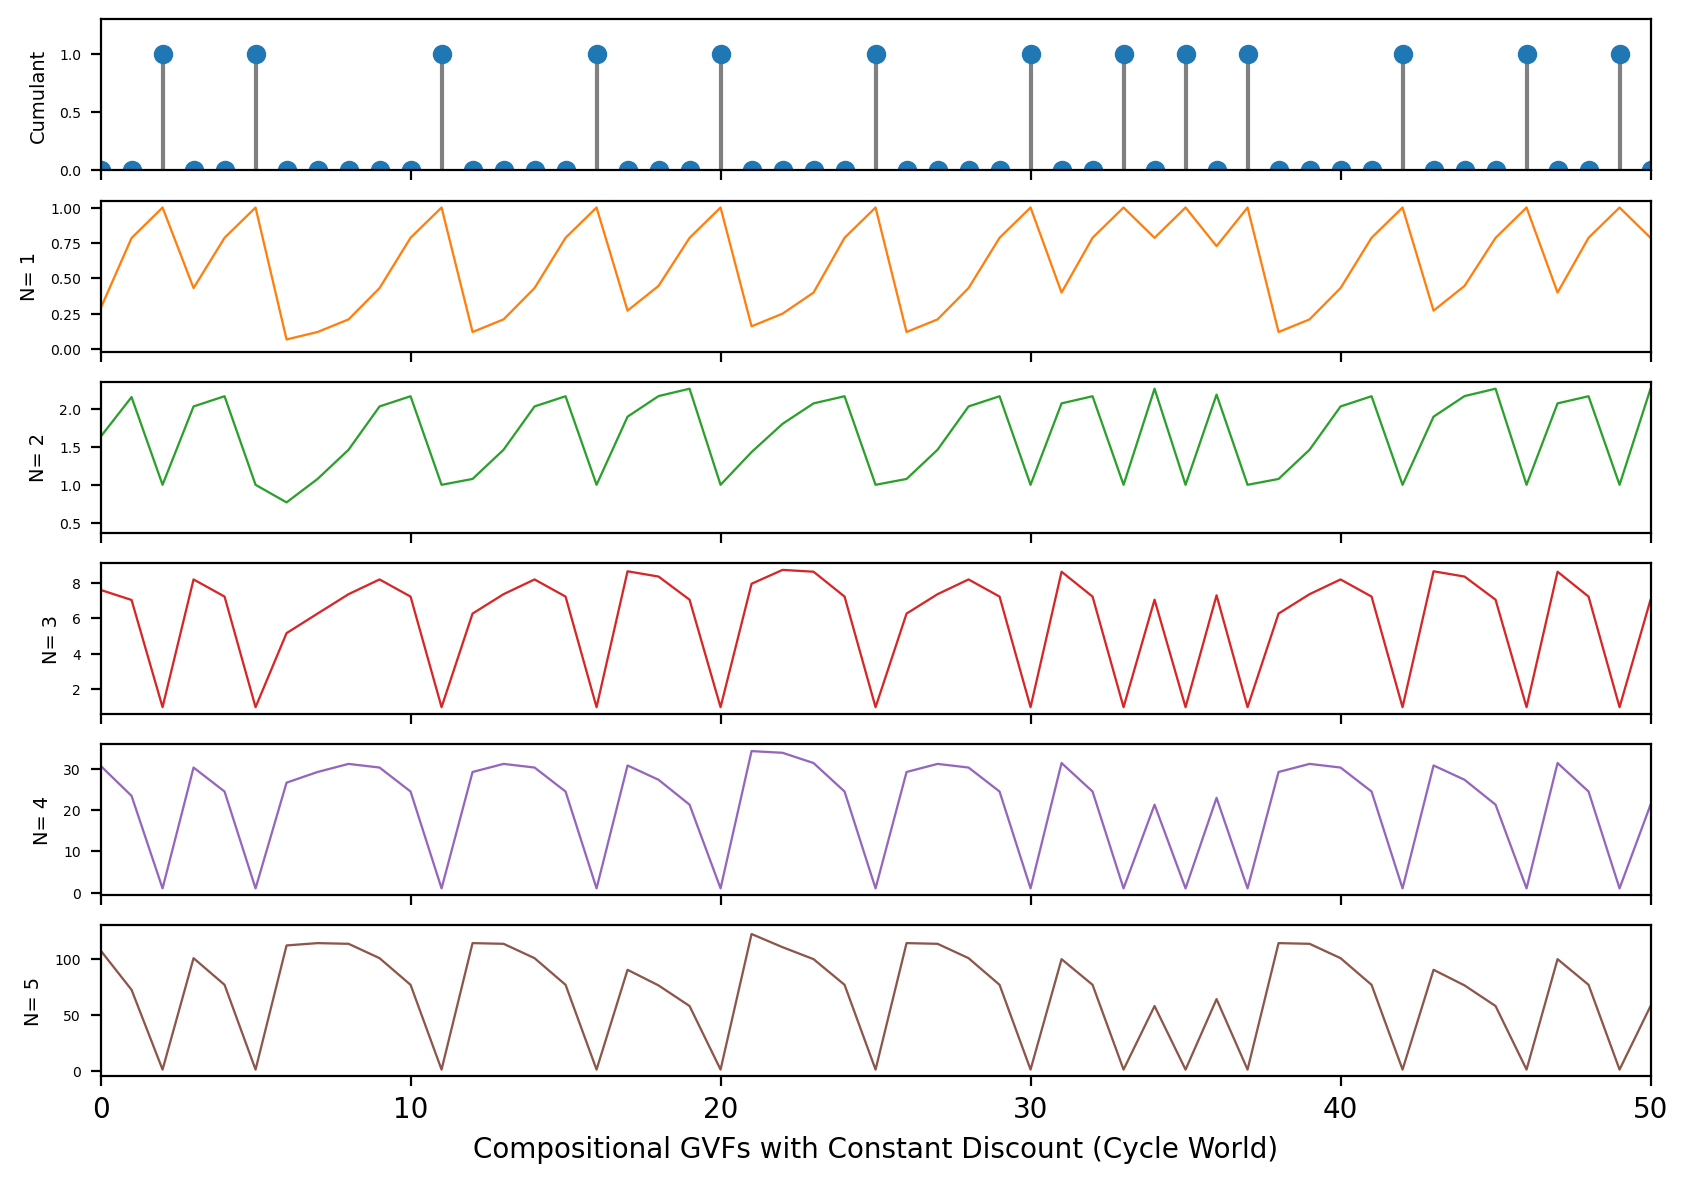

In [53]:
import matplotlib.pyplot as plt
#Return Plot
fig, axs = plt.subplots(n+1, figsize = (10, 7) ,dpi = 200, sharex=True)
plt.xlim(right = 50, left = 0)
plt.xlabel('Compositional GVFs with Constant Discount (Cycle World)')

for k in range(n+1):
    if k == 0:
        axs[k].stem(time_step, cumulant, linefmt='grey', markerfmt='C0o', bottom=-1, use_line_collection=True)
        axs[k].set_ylabel('Cumulant', fontsize = 7)
        axs[k].set(ylim=(0, 1.3))


    else:
        axs[k].plot(time_step, comp[k-1], color = colors[k], linewidth = 0.8193)
        axs[k].set_ylabel('N= ' + str(k), fontsize = 7)
    axs[k].tick_params(axis='y' , which='major', labelsize=5)
plt.savefig('CycleWorldCompGVFs.png')

# Gridworld Environment

In [54]:
from gym import spaces
from gym.utils.renderer import Renderer
import pygame
import numpy as np


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array", "single_rgb_array"], "render_fps": 30}

    def __init__(self, render_mode=None, size= 7):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down", "right"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode
        self._renderer = Renderer(self.render_mode, self._render_frame)

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

    def reset(self, seed=None, return_info=False, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        self._target_location[0] = 4
        self._target_location[1] = 4

        observation = self._get_obs()
        info = self._get_info()

        self._renderer.reset()
        self._renderer.render_step()

        return (observation, info) if return_info else observation

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        # An episode is done iff the agent has reached the target
        done = np.array_equal(self._agent_location, self._target_location)
        reward = 1 if done else 0  # Binary sparse rewards
        observation = self._get_obs()
        info = self._get_info()

        self._renderer.render_step()

        return observation, reward, done, info

    def render(self):
        return self._renderer.get_renders()

    def _render_frame(self, mode):
        assert mode is not None

        if self.window is None and mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()
            
    def fake_step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]
        # We use `np.clip` to make sure we don't leave the grid
        x = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )
        return x
    
    
    def isdone(self):
        # An episode is done iff the agent has reached the target
        done = np.array_equal(self._agent_location, self._target_location)


        return done

# TD(0) Learning of GVFs with Constant Discount

In [55]:
env = GridWorldEnv()
env.action_space.seed(42)
g = 0.9
observation, info = env.reset(seed=42, return_info=True)
observation = tuple(observation['agent'].tolist())
r = [0]
#number of compositions, change it up for fun! 
n = 5
#Tabular Value Function
v = []

for k in range(n):
    v.append({})
    for i in range(7):
        for j in range(7):
            v[k][(i,j)] = 0
            

for _ in range(100000):
    #For the first GVP, we use Reward as the cumulant
    observation_next, reward, done, info = env.step(env.action_space.sample())
    observation_next = tuple(observation_next['agent'].tolist())
    v[0][observation] = v[0][observation] + 0.01*(reward + g*v[0][observation_next] - v[0][observation])
    #Learning compositions
    for k in range(1,n):
        v[k][observation] = v[k][observation] + 0.01*(v[k-1][observation] + g*v[k][observation_next] - v[k][observation])
    observation = observation_next
    if done:
        for k in range(n):
            v[k][observation_next] = 1
        observation, info = env.reset(return_info=True)
        observation = tuple(observation['agent'].tolist())

env.close()

### Storing Compositions 

In [56]:
#Creating empty lists to store the GVFs in
time_step = []
cumulant = []
comp = []
state_value = []
reward_old = 0

for k in range(n):
    state_value.append({})
    comp.append([])
for step in range(100000):
    max_val = -919
    for i in range(4):
        obs = env.fake_step(i)
        state_value[0] = (v[0][tuple(obs.tolist())])
        if state_value[0] > max_val:
            max_val = state_value[0]
            action = i
            for k in range(1,n):
                state_value[k] = (v[k][tuple(obs.tolist())])
    reward_old = reward
    _, reward, done, _ = env.step(action)
    if reward == reward_old and reward != 0:
        continue
    time_step.append(step)
    cumulant.append(reward)
    for k in range(n):
        if k == 0:
            comp[k].append(max_val)
        else:
            comp[k].append(state_value[k])
    if done:
        env.reset(return_info=True)
        



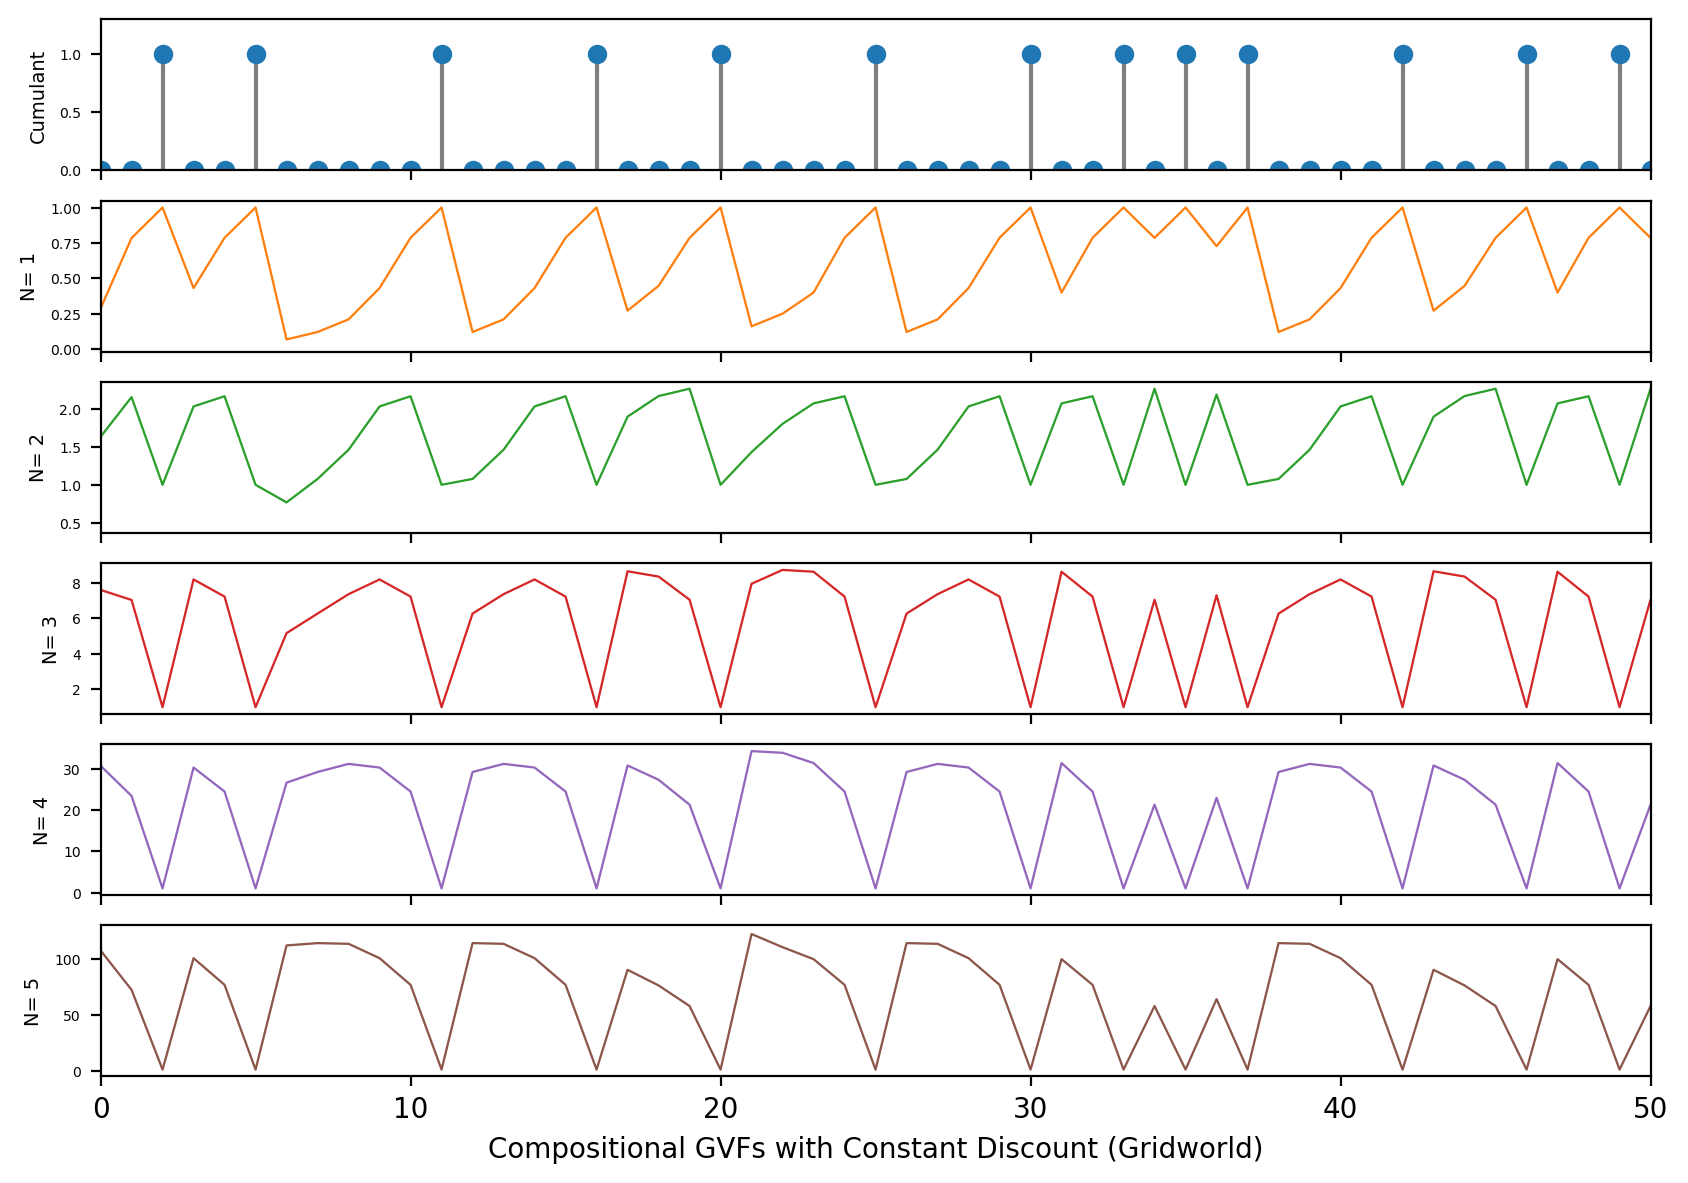

In [57]:
import matplotlib.pyplot as plt
#Return Plot
fig, axs = plt.subplots(n+1, figsize = (10, 7) ,dpi = 200, sharex=True)
plt.xlim(right = 50, left = 0)
plt.xlabel('Compositional GVFs with Constant Discount (Gridworld)')

for k in range(n+1):
    if k == 0:
        axs[k].stem(time_step, cumulant, linefmt='grey', markerfmt='C0o', bottom=-1, use_line_collection=True)
        axs[k].set_ylabel('Cumulant', fontsize = 7)
        axs[k].set(ylim=(0, 1.3))


    else:
        axs[k].plot(time_step, comp[k-1], color = colors[k], linewidth = 0.8193)
        axs[k].set_ylabel('N= ' + str(k), fontsize = 7)
    axs[k].tick_params(axis='y' , which='major', labelsize=5)
plt.savefig('GridworldCompGVFs.png')

# TD(0) Learning with Constant Discount + Gridworld Simulation

In [ ]:
#This is a Visualization of the Grid World TD(0). For the first 5000 Steps, it selects random steps to explore. 
env = GridWorldEnv("human")
env.action_space.seed(46)
g = 0.9
observation, info = env.reset(seed=46, return_info=True)
observation = tuple(observation['agent'].tolist())
action = 0

#Tabular Value Function
v = {}

#Initialize v-values to 0
for i in range(50):
    for j in range(50):
        v[(i,j)] = 0
        
#E-Greedy Policy
for step in range(100000):
    #e part of e-Greedy
    #Setting the first 5000 steps to a random walk
    if step > 5000 and np.random.random() < 0.9:
        #Greedy Part of the e-Greedy
        max_val= -919
        for i in range(4):
            obs = env.fake_step(i)
            state_value = v[0][tuple(obs.tolist())]
            if state_value > max_val:
                max_val = state_value 
                action = i
    else:
        action = np.random.choice(range(4))
        
        
        
    observation_next, reward, done, info = env.step(action)
    observation_next = tuple(observation_next['agent'].tolist())
    
    #TD(0)-Part
    v[0][observation] = v[0][observation] + 0.1*(reward + g*v[0][observation_next] - v[0][observation])
    observation = observation_next
    if done:
        v[0][observation_next] = 1
        observation, info = env.reset(return_info=True)
        observation = tuple(observation['agent'].tolist())
    

env.close()
print(v)